<a href="https://colab.research.google.com/github/namjunwoo223/Attention-is-All-You-Need-Study-NMT/blob/main/Attention_is_all_you_need_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade spacy

     |████████████████████████████████| 6.2 MB 4.2 MB/s 
     |████████████████████████████████| 653 kB 63.7 MB/s 
     |████████████████████████████████| 457 kB 55.2 MB/s 
     |████████████████████████████████| 10.1 MB 39.6 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 181 kB 61.2 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    U

In [ ]:
!python -m spacy download ja_core_news_md

     |████████████████████████████████| 42.0 MB 580 kB/s 
     |████████████████████████████████| 2.2 MB 4.4 MB/s 
  Created wheel for sudachidict-core: filename=SudachiDict_core-20211220-py3-none-any.whl size=71565353 sha256=252234ccb663f30b6a9ee9a5558c4739453a3f0d4af0896c3e6bbb261f49554f
  Stored in directory: /root/.cache/pip/wheels/17/6d/f6/f9451cbfc76ffdf985af12239191ca20721f1da5aba5005eb0
Successfully built sudachidict-core
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_md')


In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 4.2 MB/s 
     |████████████████████████████████| 448 kB 70.0 MB/s 


In [ ]:
#일본어 토크나이저 선언
import spacy

jp_tokenizer = spacy.load('ja_core_news_md')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import json
import torch
from glob import glob
from torch import nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

device = "cuda"

In [ ]:
tr_lst = glob("/content/drive/MyDrive/my/dataset/translate/train/*.csv")
va_lst = glob("/content/drive/MyDrive/my/dataset/translate/valid/*.csv")

In [ ]:
tr_lst

['/content/drive/MyDrive/my/dataset/translate/train/ko2ja_auto_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_edu_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_finance_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_folk_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_it_tech_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_kpop_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_medical_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_patent_1_training.csv',
 '/content/drive/MyDrive/my/dataset/translate/train/ko2ja_society_1_training.csv']

In [ ]:
train_data = pd.read_csv(tr_lst[0])
valid_data = pd.read_csv(va_lst[0])

In [ ]:
#일단은 ko2ja_auto_1_training.csv만을 사용하여 학습을 진행하겠습니다.

#for i in tr_lst[1:]:
#  tmp = pd.read_csv(i)
#  train_data = pd.concat([train_data, tmp])

#for i in va_lst[1:]:
#  tmp = pd.read_csv(i)
#  valid_data = pd.concat([valid_data, tmp])

In [ ]:
train_data

,관리번호,분야,한국어,일본어,한국어_어절수,일본어_글자수,길이_분류,출처,수행기관
0,KO-JA-2020-AUTO-000001,자동차/부품/교통/소재,지원 금액은 차종과 연식에 따라 보험개발원이 산정한 차량기준가액을 적용한다.,支援金額は車種と年式によって保険開発院が算定した車両基準価額を適用する。,9,35,1,http://www.asiae.co.kr/article/202005201702158...,에버트란
1,KO-JA-2020-AUTO-000002,자동차/부품/교통/소재,이 대표는 기업간거래(B2B)용 연구개발(R&D) 칩으로 수익을 내면 모바일 기기와...,イ代表は、企業間取引(B2B)用の研究開発(R&D)チップで収益を出せば、モバイル機器と自動...,18,62,3,http://www.etnews.com/20200408000179,에버트란
2,KO-JA-2020-AUTO-000003,자동차/부품/교통/소재,쌍용자동차가 코란도 스포츠의 출시를 기념해 고객들이 코란도 스포츠의 활용성을 체험할...,双龍自動車がコランドスポーツの発売を記念し、顧客がコランドスポーツの活用性を体験できる多彩な...,17,60,3,NaN,에버트란
3,KO-JA-2020-AUTO-000004,자동차/부품/교통/소재,르노삼성은 현금할인에 각종 용품 장착 지원을 통해 반등에 나선다.,ルノーサムスンは現金割引に各種用品の装着支援を通じて持ち直しを狙う。,9,32,1,NaN,에버트란
4,KO-JA-2020-AUTO-000005,자동차/부품/교통/소재,2개의 냉각수 시스템과 6기통의 복스터 엔진은 테크아트 파워 키트를 통해 개선됐다.,2つの冷却水システムと6気筒のボクスターエンジンは、テックアートパワーキットにより改善された。,11,40,2,NaN,에버트란
...,...,...,...,...,...,...,...,...,...
159995,KO-JA-2020-AUTO-160402,자동차/부품/교통/소재,프론트 그릴과 대담한 헤드라이트의 디테일 등 여러 모습은 고스란히 닛산의 감성이라 ...,フロントグリルと大胆なヘッドライトのディテールなど、様々な姿はまさに日産の感性だと思われる。,12,43,2,http://uci.or.kr/G703:RA101-01101101.201906030...,에버트란
159996,KO-JA-2020-AUTO-160403,자동차/부품/교통/소재,"반도체 강자 인텔이 차세대 먹거리로 모빌리티, 그중에서도 '자율주행'을 점찍고 활발...",半導体強者インテルが次世代の食としてモビリティ、その中でも「自動運転」を狙って活発な動きを見...,13,47,2,https://www.hankyung.com/it/article/202005075095g,에버트란
159997,KO-JA-2020-AUTO-160404,자동차/부품/교통/소재,H2R은 BMW그룹이 프랑스 미라마스 시험장에서 가진 성능측정시험에서 9개의 기록을...,H2Rは、BMWグループがフランスのミラマス試験場で行った性能測定試験で、9つの記録を作成し...,12,48,2,NaN,에버트란
159998,KO-JA-2020-AUTO-160405,자동차/부품/교통/소재,따라서 즉각적인 가속준비도 하고 엔진 브레이크 전환도 빠르다.,したがって、即時加速の準備もできてエンジンブレーキの切り替えも早い。,8,31,1,NaN,에버트란


In [ ]:
valid_data, test_data = train_test_split(valid_data, test_size = 0.2, random_state=42)

In [ ]:
valid_data

,관리번호,분야,한국어,일본어,한국어_어절수,일본어_글자수,길이_분류,출처,수행기관
5894,KO-JA-2020-AUTO-166313,자동차/부품/교통/소재,"주행 모드로 '에코', '컴포트', '스포츠', '인디비주얼 모드'를 제공한다.",走行モードとして「エコ」、「コンフォート」、「スポーツ」、「インディビジュアルモード」を提供する。,8,33,1,https://www.hankyung.com/economy/article/20200...,에버트란
3728,KO-JA-2020-AUTO-164142,자동차/부품/교통/소재,여기에 우버가 이날부터 자율주행 택시 서비스를 개시하면서 자율주행차는 먼 미래가 아...,さらに、ウーバーが同日から、自主走行タクシーサービスを開始し、自主走行車は遠い未来ではなく、...,19,66,3,NaN,에버트란
8958,KO-JA-2020-AUTO-169382,자동차/부품/교통/소재,"시트로엥 C5 에어크로스의 가장 큰 매력은 바로 파워트레인의 완성도, 그리고 주행 ...",「シトロエンC5エアクロス」の最大の魅力は、パワートレインの完成度、そして走行状況で現れるシ...,19,64,3,http://uci.or.kr/G703:RA101-01101101.202001070...,에버트란
7671,KO-JA-2020-AUTO-168092,자동차/부품/교통/소재,"트렁크 게이트를 가로 질러 길게 이어지는 리어 콤비네이션 램프를 갖췄으며, 직선이 ...",トランクゲートを横切って長く続くリアコンビネーションランプを備えており、直線ではなく曲線を中...,22,71,4,http://uci.or.kr/G703:RA101-01101101.202001140...,에버트란
5999,KO-JA-2020-AUTO-166418,자동차/부품/교통/소재,더욱이 볼보의 성장은 수요를 따라가지 못하는 공급에도 불구하고 이뤄낸 것이어서 더 ...,さらにボルボの成長は、需要に追いつけない供給にもかかわらず成し遂げたものであり、もっと驚くべ...,12,48,2,http://www.sedaily.com/NewsView/1VS7N78J3D,에버트란
...,...,...,...,...,...,...,...,...,...
11284,KO-JA-2020-AUTO-171712,자동차/부품/교통/소재,포드세일즈서비스코리아의 Explorer 등 미판매 2개 차종 511대는 2열 바깥쪽...,フォードセールスサービスコリアのExplorerなど、未販売の2つの車種511台は、2列の外...,15,56,3,https://www.nocutnews.co.kr/news/5243385,에버트란
11964,KO-JA-2020-AUTO-172398,자동차/부품/교통/소재,인공지능 기반으로 차량의 돌발 정지와 역주행을 자동으로 감지하는 스마트 CCTV가 ...,人工知能をベースにして車両の突発停止と逆走を自動的に感知するスマートCCTVが、2025年ま...,12,42,2,NaN,에버트란
5390,KO-JA-2020-AUTO-165807,자동차/부품/교통/소재,또 자동차 할부시 취급수수료를 별도로 받는 경우가 있기 때문에 금리 비교는 취급수수...,また、自動車ローンの場合、取扱手数料を別途に受け取ることがあるため、金利の比較は取扱手数料を...,17,62,3,NaN,에버트란
860,KO-JA-2020-AUTO-161270,자동차/부품/교통/소재,지난해 7월 일본차 불매 운동 이후 출시된 첫 신차의 결과에 도요타코리아를 비롯한 ...,昨年7月、日本車不買運動以後、発売された初の新車の結果に、トヨタコリアをはじめ、日本車業界が...,16,54,3,https://www.hankyung.com/life/article/20200123...,에버트란


In [ ]:
test_data

,관리번호,분야,한국어,일본어,한국어_어절수,일본어_글자수,길이_분류,출처,수행기관
10650,KO-JA-2020-AUTO-171077,자동차/부품/교통/소재,"도요타통상은 베트남 국영광물공사와 합작으로 광산회사를 설립, 하노이 북부의 본파오 ...",豊田通商は、ベトナム国営鉱物公社と合弁で鉱山会社を設立、ハノイ北部のヴォルンパオ鉱山で201...,15,55,3,NaN,에버트란
2041,KO-JA-2020-AUTO-162452,자동차/부품/교통/소재,해를 넘긴 기아차 노사의 임단협 교섭이 타결 국면으로 들어서고 있다.,年を越した起亜自動車の労使の賃金団体交渉が妥結局面に入っている。,10,31,2,http://www.fnnews.com/news/202001151816399438,에버트란
8668,KO-JA-2020-AUTO-169091,자동차/부품/교통/소재,레벨4 클라우드 기반 맵의 도움을 받는 것을 넘어 차량과 인프라가 협력해서 제어하는...,レベル4のクラウドベースマップの助けを受けることを越え、車とインフラが協力して制御する方式で...,14,48,2,NaN,에버트란
1114,KO-JA-2020-AUTO-161524,자동차/부품/교통/소재,BMW코리아는 5시리즈 부분변경 모델을 세계 최초로 한국에서 공개한다.,BMWコリアは、5シリーズのマイナーチェンジモデルを、世界で初めて韓国で公開する。,8,32,1,http://www.sedaily.com/NewsView/1YXJ1UHDNF,에버트란
13902,KO-JA-2020-AUTO-174342,자동차/부품/교통/소재,나머지 대형 완성차업체들이 눈치를 보며 새 제도의 도입을 차일피일 미루는 가운데 연...,他の大手完成車メーカー各社がお互いを気にしすぎて、新しい制度の導入をずるずると延ばすうちに、...,19,68,3,NaN,에버트란
...,...,...,...,...,...,...,...,...,...
4073,KO-JA-2020-AUTO-164487,자동차/부품/교통/소재,919 하이브리드는 오는 5월2일 스파프랑코르샹 6시간 챔피언십 참전에 이어 6월1...,919ハイブリッドは、5月2日のスパ・フランコルシャン6時間チャンピオンシップ参戦に続き、6...,15,54,3,NaN,에버트란
7442,KO-JA-2020-AUTO-167862,자동차/부품/교통/소재,스마트스트림 D2.2는 알루미늄 블록을 적용하고 최적의 설계를 통해 기존 R2.2 ...,スマートストリームD2.2は、アルミブロックを適用した最適な設計により、既存のR2.2エンジ...,14,45,2,http://uci.or.kr/G703:RA101-10100101.202003181...,에버트란
9999,KO-JA-2020-AUTO-170425,자동차/부품/교통/소재,"지난 2월, 한국 자동차 업계의 생산량은 지난해 2월과 비교해 26.4%나 감소했다.",今年2月、韓国自動車業界の生産量は昨年2月に比べ26.4%も減少した。,11,26,2,https://www.nocutnews.co.kr/news/5327849,에버트란
1870,KO-JA-2020-AUTO-162281,자동차/부품/교통/소재,"자동차업계 관계자는 ""엔트리 모델은 해당 브랜드에 대한 첫인상을 결정한다""며 ""첫 ...",自動車業界の関係者は「エントリーモデルは該当ブランドに対する第一印象を決定する」とし「初めて...,30,117,6,https://www.hankyung.com/economy/article/20200...,에버트란


In [ ]:
train_data["일본어"].iloc[2]

'双龍自動車がコランドスポーツの発売を記念し、顧客がコランドスポーツの活用性を体験できる多彩なイベントを実施すると、15日明らかにした。'

In [ ]:
tokenized = jp_tokenizer.tokenizer(train_data["일본어"].iloc[2])

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: 双龍
인덱스 1: 自動車
인덱스 2: が
인덱스 3: コランド
인덱스 4: スポーツ
인덱스 5: の
인덱스 6: 発売
인덱스 7: を
인덱스 8: 記念
인덱스 9: し
인덱스 10: 、
인덱스 11: 顧客
인덱스 12: が
인덱스 13: コランド
인덱스 14: スポーツ
인덱스 15: の
인덱스 16: 活用
인덱스 17: 性
인덱스 18: を
인덱스 19: 体験
인덱스 20: できる
인덱스 21: 多彩
인덱스 22: な
인덱스 23: イベント
인덱스 24: を
인덱스 25: 実施
인덱스 26: する
인덱스 27: と
인덱스 28: 、
인덱스 29: 15
인덱스 30: 日
인덱스 31: 明らか
인덱스 32: に
인덱스 33: し
인덱스 34: た
인덱스 35: 。


In [ ]:
from konlpy.tag import Okt

okt = Okt()

In [ ]:
okt.morphs(train_data["한국어"].iloc[2])

['쌍용',
 '자동차',
 '가',
 '코란도',
 '스포츠',
 '의',
 '출시',
 '를',
 '기념',
 '해',
 '고객',
 '들',
 '이',
 '코란도',
 '스포츠',
 '의',
 '활용',
 '성',
 '을',
 '체험',
 '할',
 '수',
 '있는',
 '다',
 '채',
 '로운',
 '이벤트',
 '를',
 '실시',
 '한다고',
 '15일',
 '밝혔다',
 '.']

In [ ]:
#import time
#from datetime import timedelta

#test
#def tokenize_kr(text):
#    start = time.process_time() 
#    lst = []
#
#    for idx, i in enumerate(text):
#        tmp = okt.morphs(i)
#        lst.append(tmp)
#        if idx % 10000 == 0:
#          print(f"{idx} : {timedelta(seconds=time.process_time() - start)} sec")
#
#    end = time.process_time()
#    print(f"{timedelta(seconds=end - start)} sec")
#    return lst

In [ ]:
#tokenize_kr(train_data["한국어"].tolist())

In [ ]:
def tokenize_jp(text):
    return [token.text for token in jp_tokenizer.tokenizer(text)]

def tokenize_kr(text):
    return okt.morphs(text)

In [ ]:
from itertools import chain

class jp_vocab_dict:
  def __init__(self):
    self.word_dict = {'<unk>': 0, "<pad>": 1,
                      '<sos>': 2, "<eos>": 3}

  def preprocessing(self, sequences):
    result = []

    for i in sequences:
      result.append([token.text for token in jp_tokenizer.tokenizer(i)])

    words_set = set(chain(*result))
    idx = 3

    for index, i in enumerate(words_set):
        if index % 10000 == 0:
          print(index)
        self.word_dict[i] = idx+1
        idx += 1


class kr_vocab_dict:
  def __init__(self):
    self.word_dict = {'<unk>': 0, "<pad>": 1,
                      '<sos>': 2, "<eos>": 3}

  def preprocessing(self, sequences):
    result = []

    for i in sequences:
      result.append(okt.morphs(i))

    words_set = set(chain(*result))
    idx = 3

    for index, i in enumerate(words_set):
        if index % 10000 == 0:
          print(index)
        self.word_dict[i] = idx+1
        idx += 1

In [ ]:
jp_vocab_dict = jp_vocab_dict()
kr_vocab_dict = kr_vocab_dict()

In [ ]:
jp_vocab_dict.preprocessing(pd.concat([train_data["일본어"], valid_data["일본어"], test_data["일본어"]]))
kr_vocab_dict.preprocessing(pd.concat([train_data["한국어"], valid_data["한국어"], test_data["한국어"]]))

0
10000
20000
30000
40000
50000
0
10000
20000
30000
40000
50000
60000
70000


In [ ]:
def collate_fn(batch):
    jp_list, kr_list, src, trg = [], [], [], []
    #print(batch[0]) src
    #print(batch[1]) trg

    for i in range(len(batch)):
      jp_ids = [jp_vocab_dict.word_dict[x] for x in [token.text for token in jp_tokenizer.tokenizer(batch[i][0])]]
      jp_list.append(jp_ids)
      kr_ids = [kr_vocab_dict.word_dict[x] for x in okt.morphs(batch[i][1])]
      kr_list.append(kr_ids)

    jp_padding_len = max([len(x) for x in jp_list])
    kr_padding_len = max([len(x) for x in kr_list])

    for i in jp_list:
      if len(i) <= jp_padding_len:
        padding_cnt = jp_padding_len - len(i)
        for __ in range(padding_cnt):
          i.append(1)
        src.append(i)

    for i in kr_list:  
      if len(i) <= kr_padding_len:
        padding_cnt = kr_padding_len - len(i)
        for __ in range(padding_cnt):
          i.append(1)
        trg.append(i)

    for i in range(len(src)):
      src[i].insert(0, 2)
      trg[i].insert(0, 2)
      src[i].append(3)
      trg[i].append(3)

    return {"src": torch.LongTensor(src).to(device), "trg": torch.LongTensor(trg).to(device)}

In [ ]:
class jptokrDataset(Dataset):
    def __init__(self, src:list, trg:list) -> tuple:
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)
        
    def __getitem__(self, index):
        return self.src[index], self.trg[index]

train_dataset = jptokrDataset(train_data['일본어'].to_list(), train_data["한국어"].to_list())
valid_dataset = jptokrDataset(valid_data['일본어'].to_list(), valid_data["한국어"].to_list())
test_dataset = jptokrDataset(test_data['일본어'].to_list(), test_data["한국어"].to_list())

In [ ]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    collate_fn = collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = BATCH_SIZE,
    collate_fn = collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    collate_fn = collate_fn
)

In [ ]:
for i, batch in enumerate(train_dataloader):
    print(batch)
    if i == 5:
      break

{'src': tensor([[    2, 37680, 15404,  ...,     1,     1,     3],
        [    2,  4330, 49866,  ...,     1,     1,     3],
        [    2, 30542, 32618,  ...,     1,     1,     3],
        ...,
        [    2, 53960, 30875,  ...,     1,     1,     3],
        [    2, 53960, 30875,  ...,     1,     1,     3],
        [    2, 19326,  8990,  ...,     1,     1,     3]], device='cuda:0'), 'trg': tensor([[    2, 58887, 55240,  ...,     1,     1,     3],
        [    2, 35763, 46223,  ...,     1,     1,     3],
        [    2,  1981,  1682,  ...,     1,     1,     3],
        ...,
        [    2, 10930, 26968,  ...,     1,     1,     3],
        [    2, 10930, 60591,  ...,     1,     1,     3],
        [    2, 62343,  5650,  ...,     1,     1,     3]], device='cuda:0')}
{'src': tensor([[    2, 53575, 25559,  ...,     1,     1,     3],
        [    2, 36806, 47828,  ...,     1,     1,     3],
        [    2, 50487, 51761,  ...,     1,     1,     3],
        ...,
        [    2, 54089, 46216, 

In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

In [ ]:
INPUT_DIM = len(jp_vocab_dict.word_dict)
OUTPUT_DIM = len(kr_vocab_dict.word_dict)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
SRC_PAD_IDX = 1
TRG_PAD_IDX = 1

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 54,635,254 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(57233, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )


In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch["src"]
        trg = batch["trg"]

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch["src"]
            trg = batch["trg"]

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 19m 46s
	Train Loss: 3.798 | Train PPL: 44.608
	Validation Loss: 1.855 | Validation PPL: 6.389
Epoch: 02 | Time: 19m 37s
	Train Loss: 1.505 | Train PPL: 4.506
	Validation Loss: 1.180 | Validation PPL: 3.255
Epoch: 03 | Time: 19m 28s
	Train Loss: 0.990 | Train PPL: 2.691
	Validation Loss: 1.033 | Validation PPL: 2.810
Epoch: 04 | Time: 19m 20s
	Train Loss: 0.766 | Train PPL: 2.151
	Validation Loss: 0.997 | Validation PPL: 2.710
Epoch: 05 | Time: 19m 22s
	Train Loss: 0.631 | Train PPL: 1.880
	Validation Loss: 0.989 | Validation PPL: 2.688
Epoch: 06 | Time: 19m 22s
	Train Loss: 0.543 | Train PPL: 1.721
	Validation Loss: 0.985 | Validation PPL: 2.677
Epoch: 07 | Time: 19m 30s
	Train Loss: 0.483 | Train PPL: 1.621
	Validation Loss: 0.991 | Validation PPL: 2.693
Epoch: 08 | Time: 19m 26s
	Train Loss: 0.437 | Train PPL: 1.548
	Validation Loss: 1.012 | Validation PPL: 2.752
Epoch: 09 | Time: 19m 37s
	Train Loss: 0.400 | Train PPL: 1.492
	Validation Loss: 1.032 | Validation PP

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_vocab_dict, trg_vocab_dict, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('ja_core_news_md')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = ["<sos>"] + tokens + ["<eos>"]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    #src_indexes = [src_vocab_dict.word_dict[x] for x in tokens]
    src_indexes = []

    for i in tokens:
      try:
        src_indexes.append(src_vocab_dict.word_dict[i])
      except:
        src_indexes.append(0)

    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [2]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == 3:
            break
            
    decode_kr = {v:k for k,v in kr_vocab_dict.word_dict.items()}

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [decode_kr[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [ ]:
#example_idx = 139

src = "このごろ自動車は値段が高い" 
trg = "요즘 자동차는 가격이 비싸다."

#src = test_dataset[example_idx][0]
#trg = test_dataset[example_idx][1]

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, jp_vocab_dict, kr_vocab_dict, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: このごろ自動車は値段が高い
타겟 문장: 요즘 자동차는 가격이 비싸다.
전체 소스 토큰: ['<sos>', 'このごろ', '自動車', 'は', '値段', 'が', '高い', '<eos>']
소스 문장 인덱스: [2, 54274, 32618, 47828, 43936, 25820, 5482, 3]
모델 출력 결과: 요즘 자동차 는 값 이 비싼 가격 이 비싼 데 대해 중고차 는 값 이 비싼 게 비싼 것 으로 중고차 는 값 이 비싼 셈 이다 . <eos>


In [ ]:
import random

for i in range(10):
  print(f"======================{i}번째 번역=======================")
  randomint = random.randint(0, 1200)

  src = test_dataset[randomint][0]
  trg = test_dataset[randomint][1]

  print(f'소스 문장: {src}')
  print(f'타겟 문장: {trg}')
  print()

  translation, attention = translate_sentence(src, jp_vocab_dict, kr_vocab_dict, model, device, logging=True)
  print()
  print("모델 출력 결과:", " ".join(translation))
  print()
  print("========================================================")

======================0번째 번역=======================
소스 문장: 消費者がこの特典を受けて購入した新車台数は、38万台に達すると推計されている。
타겟 문장: 소비자들이 이 혜택을 받아 구매한 신차 대수는 38만 대에 달하는 것으로 추산되고 있다.

전체 소스 토큰: ['<sos>', '消費', '者', 'が', 'この', '特典', 'を', '受け', 'て', '購入', 'し', 'た', '新車', '台数', 'は', '、', '38万', '台', 'に', '達する', 'と', '推計', 'さ', 'れ', 'て', 'いる', '。', '<eos>']
소스 문장 인덱스: [2, 5474, 26650, 25820, 20475, 46637, 46216, 22012, 25691, 52507, 1118, 11395, 25207, 53268, 47828, 30875, 21656, 41376, 13430, 45303, 36761, 45478, 873, 25200, 25691, 3973, 48398, 3]

모델 출력 결과: 소비자 가 이 혜택 을 받아 구매 한 신차 대수 는 38만 대에 이를 것 으로 추산 되고 있다 . <eos>

======================1번째 번역=======================
소스 문장: 3世代に渡って進化した新型Z4はトヨタスープラと骨組み、パワートレインを共有する。
타겟 문장: 3세대에 걸쳐 진화한 신형 Z4는 토요타 수프라와 뼈대, 파워트레인을 공유한다.

전체 소스 토큰: ['<sos>', '3', '世代', 'に', '渡っ', 'て', '進化', 'し', 'た', '新型', 'z', '4', 'は', 'トヨタスープラ', 'と', '骨組み', '、', 'パワー', 'トレイン', 'を', '共有', 'する', '。', '<eos>']
소스 문장 인덱스: [2, 27979, 31079, 13430, 17771, 25691, 36638, 1118, 11395, 38330, 3489, 54762, 4

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38867 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22770 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20250 missing from current font.
  font.set_

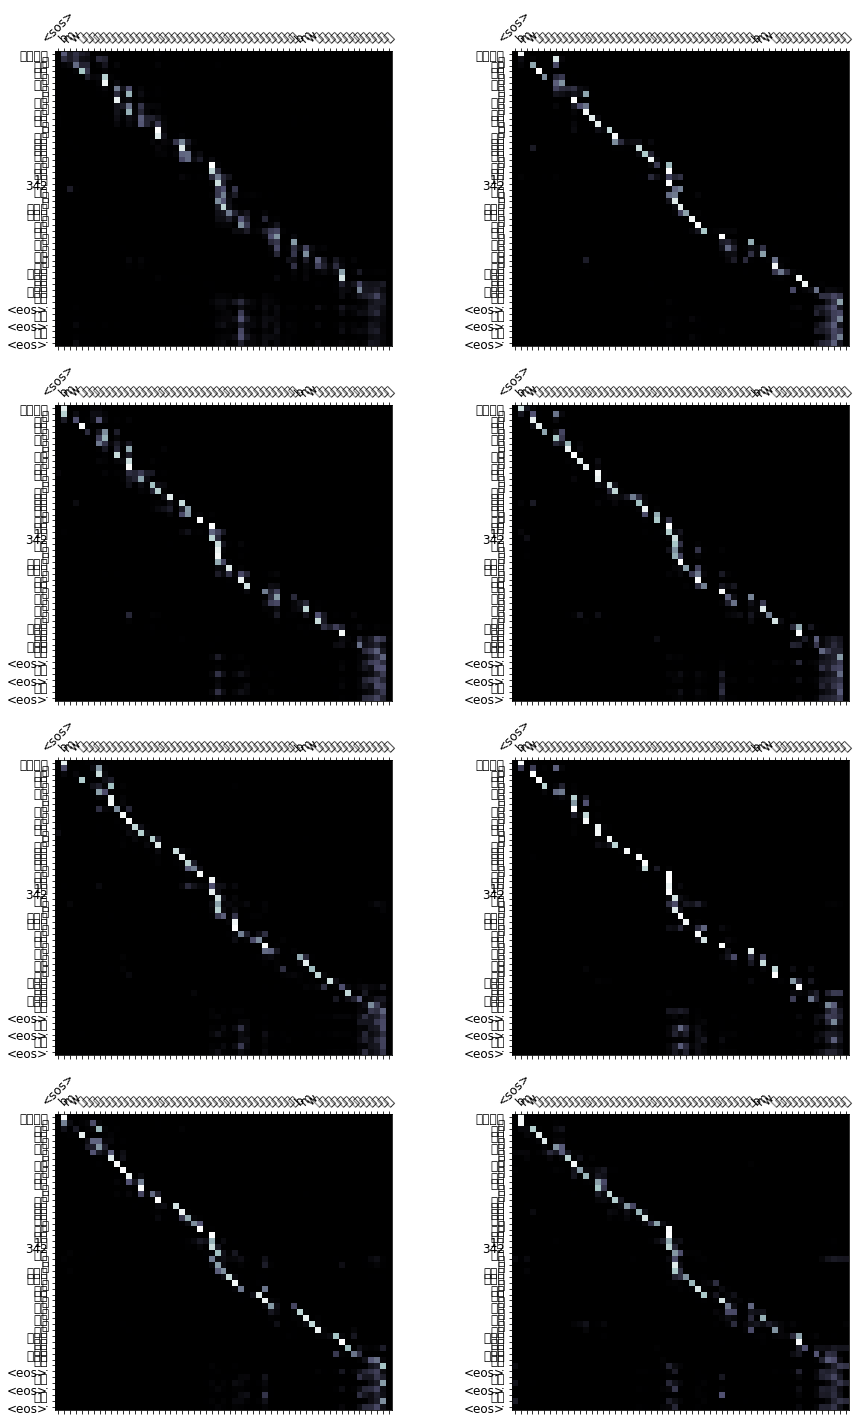

In [ ]:
display_attention(src, translation, attention)